In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold

#The model
from sklearn.svm import OneClassSVM


#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings 
warnings.simplefilter("ignore")

In [2]:
class AnomalyDetectionDataLoader:
    
    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = MinMaxScaler()

    def load_data(self):
        # Charger les données depuis le fichier CSV
        self.data = pd.read_csv(self.file_path)

        # Supprimer les duplicatas en conservant la dernière occurrence
        self.data.drop_duplicates(keep="last", inplace=True)

        # Extraire la variable cible et les caractéristiques
        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def preprocess_data(self):
        # Normaliser les caractéristiques avec Min-Max Scaling
        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):
        # Diviser les données en ensembles d'entraînement et de test
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler



In [3]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1
        
    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1
        
    elif isinstance(target,np.ndarray): 
        target[target==1]=0
        target[target==-1]=1
    return target

In [4]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
 
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytest,ypred)

In [5]:
class CustomGridSearchCV:
    
    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):
        
        
        param_grid = ParameterGrid(self.param_grid)
        skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)
        
        for params in tqdm(param_grid):
            
            
            total_score = 0

            # Itérer sur les plis de la validation croisée
            for train_index, val_index in tqdm(skf.split(X,y)):
                xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
                ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

                # Entraîner le modèle
                model = self.estimator.set_params(**params)
                model.fit(xtrain_fold)

                # Faire des prédictions
                ypred_val = model.predict(xval_fold)
                ypred_val = inverse_transform_target(ypred_val)

                current_score = f1_score(ypred_val, yval_fold)

                total_score += current_score

            avg_score = total_score / self.n_splits

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,xtest):
        return self.best_estimator.fit_predict(xtest)

In [6]:
# Utilisation de la classe
data_loader = AnomalyDetectionDataLoader(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv")
data_loader.load_data()
data_loader.preprocess_data()
data_loader.split_data()

xtrain, ytrain = data_loader.get_train_data()
xtest, ytest = data_loader.get_test_data()
scaler = data_loader.get_scaler()


In [7]:
# best_par={
#           'kernel': ["rbf"],
#           'nu': [0.0026,0.00265,0.0027], #0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#           # 'degree':[1,2,3,4,5,6,7,8,9,10]
# }
# model=CustomGridSearchCV(estimator=OneClassSVM(gamma='auto'), param_grid=best_par, n_splits=5, random_state=42)
# model.fit(xtrain,ytrain)

In [8]:
# params={'kernel': 'rbf', 'nu': 0.0026,'gamma':'auto'}

In [9]:
# clf=OneClassSVM(**params)
# clf.fit(xtrain)

In [10]:
# ypred=clf.predict(xtest)

In [11]:
# ypred=inverse_transform_target(ypred)

In [12]:
# evaluation(ytest,ypred)

In [13]:
# best_par={
#           'kernel': ["poly"],
#           'nu': [0.0026,0.003], #0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#           'degree':[1,2,3,4,5,6,7,8,9,10]
# }
# model=CustomGridSearchCV(estimator=OneClassSVM(gamma='auto'), param_grid=best_par, n_splits=5, random_state=42)
# model.fit(xtrain,ytrain)

In [14]:
params={'kernel': 'poly', 'nu': 0.0026,'gamma':'auto','degree':9}

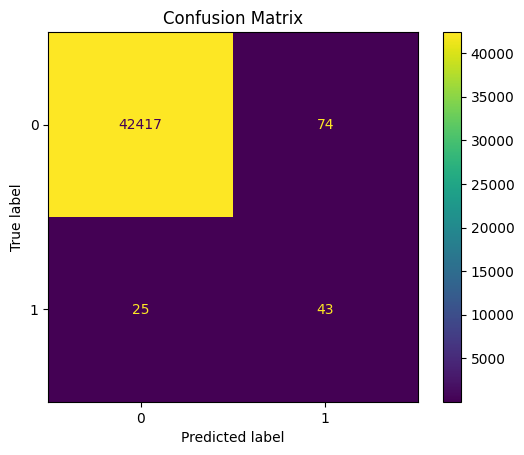

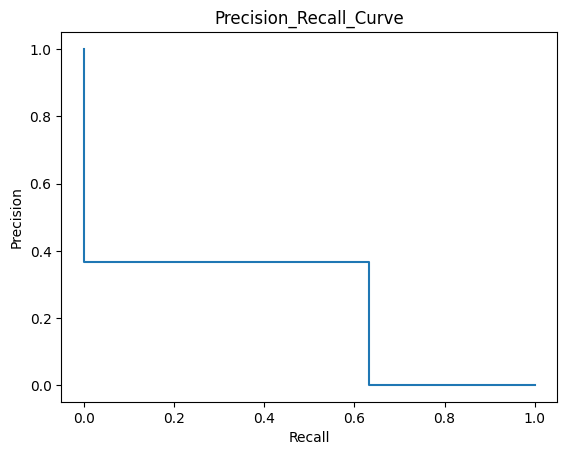

roc_auc 0.8153056979540304


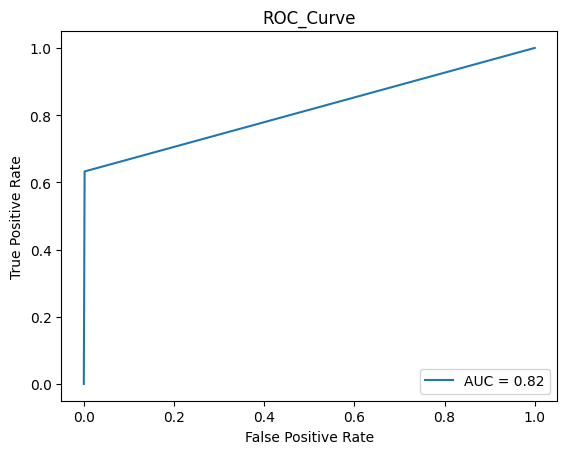

   f1_score  accuracy_score  precision_score  recall_score
0  0.464865        0.997674         0.367521      0.632353


In [15]:
params={'kernel': 'poly', 'nu': 0.0026,'gamma':'auto','degree':9}
clf=OneClassSVM(**params)
clf.fit(xtrain)

ypred=clf.predict(xtest)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

In [16]:
ypred=clf.predict(xtest)

In [17]:
ypred=inverse_transform_target(ypred)

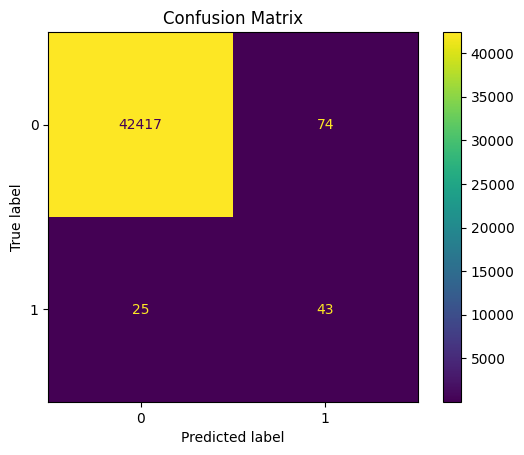

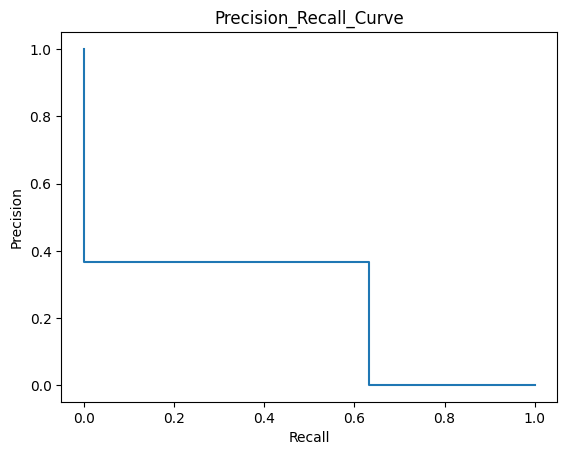

roc_auc 0.8153056979540304


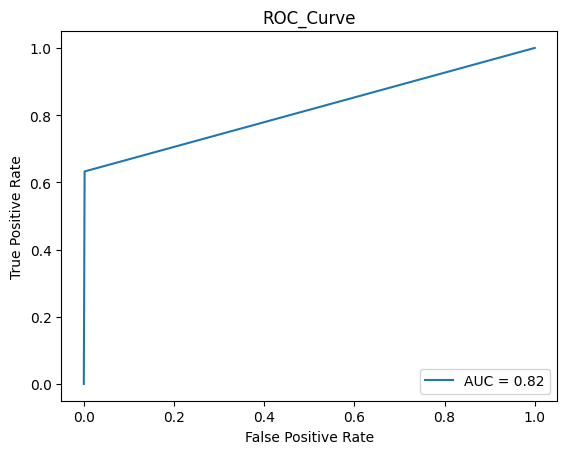

   f1_score  accuracy_score  precision_score  recall_score
0  0.464865        0.997674         0.367521      0.632353


In [18]:
evaluation(ytest,ypred)

In [52]:
best_par={
          'kernel': ["sigmoid"],
          'nu': [0.001,0.002,0.0026,0.003], #0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
          'degree':[1,2,3,4,5,6,7,8,9,10]
}
model=CustomGridSearchCV(estimator=OneClassSVM(gamma='auto'), param_grid=best_par, n_splits=5, random_state=42)
model.fit(xtrain,ytrain)

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 
Meilleurs paramètres : {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.002}
Meilleur score moyen (f1_score) : 0.42897657390971167


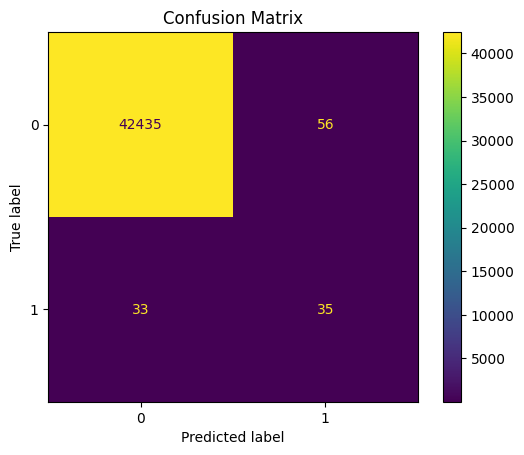

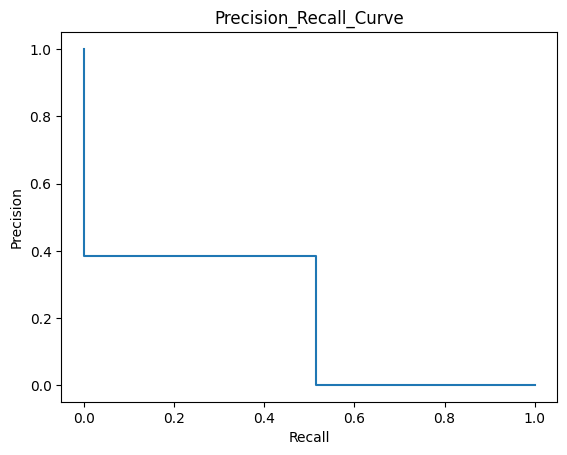

roc_auc 0.7566939781019372


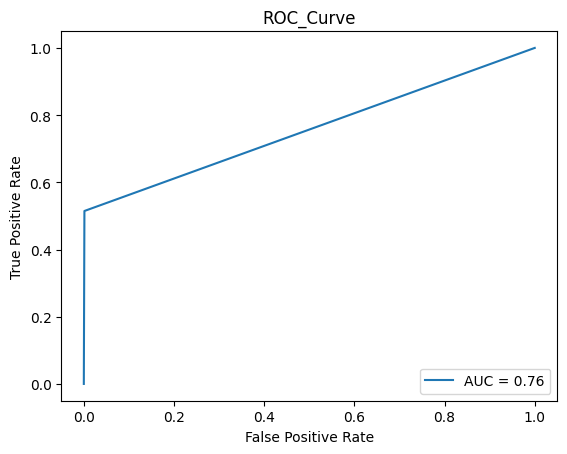

   f1_score  accuracy_score  precision_score  recall_score
0  0.440252        0.997909         0.384615      0.514706


In [54]:
params={'kernel': 'sigmoid', 'nu': 0.002,'gamma':'auto','degree':1}
clf=OneClassSVM(**params)
clf.fit(xtrain)

ypred=clf.predict(xtest)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)